# Gradient Descent Doesn't Find a Local Minimum in a Two Layer Linear Net

$$\newcommand{\E}{\mathop{\mathbb{E}}}
\newcommand{\L}{\mathop{\mathcal{L}}}$$

I'll fit a two layer neural net on a realizable problem.

The loss function to find matrices $W_1$ and $W_2$ that minimize 

$$\begin{align}
\L(W_1, W_2) &= \E_{x \sim \mathcal{N}(0,\; I)} \|W_1 W_2 x - y\|^2 \\
y &= Ax
\end{align}$$

where $A$ is a badly conditioned matrix ($\kappa = 10^5$).

This problem is matrix factorization in thin disguise:
$$\begin{align}
\L &= \E \|(W_1W_2 -A)x\|^2 \\
&= \text{tr}\;  (W_1W_2-A)\left(\E xx^T\right)(W_1W_2-A)^T \\
&= \|W_1W_2-A\|_F^2.
\end{align}$$

# Gradient Descent and Variants

In [0]:
import tensorflow as tf
import matplotlib.pylab as plt
import numpy as np
from scipy import sparse

In [0]:
class TwoLayerLinearNet(object):
  
  def __init__(self, name, X, Ytrue, W1_initial, W2_initial):
    W1 = tf.Variable(W1_initial, trainable=True)
    W2 = tf.Variable(W2_initial, trainable=True)
    
    # Yhat = W1 W2 X
    Yhat = tf.matmul(W1, tf.matmul(W2, X))
    self.variables = (W1, W2)

    # loss = || Yhat - Ytrue ||^2
    loss = tf.reduce_sum(tf.squared_difference(Yhat, Ytrue))
    self.loss = loss
    
    # a tensor that stores the sum of the frobenius norms of the gradients of
    # the loss wrt to the parameters
    self.gradient_magnitude = tf.sqrt(sum([
        tf.reduce_sum(dLdvar**2)
        for dLdvar in tf.gradients(loss, self.variables)
    ]))
    
    # this optimizer must be set before calling run_optimizer
    self.optimizer_op = None 
    self.name = name
    self.losses = []
    self.plot_kwargs = {}
    
  def run_optimizer(self, sess, num_steps):
    self.losses = []
    self.gradient_magnitudes = []
    
    for it in xrange(num_steps):
      loss, gradient_magnitude, _ = sess.run([
          self.loss,
          self.gradient_magnitude,
          self.optimizer_op
      ])

      self.losses.append(loss)
      self.gradient_magnitudes.append(gradient_magnitude)

      # stop iterating if the loss has diverged
      if not np.isfinite(self.losses[-1]):
        break

        
class NetGradientDescent(TwoLayerLinearNet):
  
  def __init__(self, learning_rate, *args, **kwargs):
    TwoLayerLinearNet.__init__(self, 'GD step=%g' % learning_rate,
                               *args, **kwargs)
    
    self.optimizer_op = tf.train.GradientDescentOptimizer(
        learning_rate).minimize(self.loss, var_list=self.variables)
        

class NetADAM(TwoLayerLinearNet):
  
  def __init__(self, learning_rate, *args, **kwargs):
    TwoLayerLinearNet.__init__(self, 'ADAM step=%g' % learning_rate,
                               *args, **kwargs)
    
    self.optimizer_op = tf.train.AdamOptimizer(
        learning_rate).minimize(self.loss, var_list=self.variables)
    self.plot_kwargs = {'ls': '--'}

In [0]:
def train_nets(xdim=6, wdim=6, ydim=10, nsamples=1000,
               A_condition_number=1e-5):
    W1_initial = np.random.randn(ydim, wdim)
    W2_initial = np.random.randn(wdim, xdim)

    # the true map from x to y
    Atrue = np.linspace(1, A_condition_number, ydim
                       ).reshape(-1, 1) * np.random.rand(ydim, xdim)
    # the inputs
    X = np.random.randn(xdim, nsamples)
    # the y's to fit
    Ytrue = Atrue.dot(X)

    nets = [
        NetGradientDescent(learning_rate, X, Ytrue, W1_initial, W2_initial)
        for learning_rate in [1e-6, 1e-5, 1e-4, 1e-3]
    ] + [
        NetADAM(learning_rate, X, Ytrue, W1_initial, W2_initial)
        for learning_rate in [1e-5, 1e-4, 1e-3, 1e-2]
    ]
    
    with tf.Session() as sess:
      sess.run(tf.global_variables_initializer())

      for net in nets:
        net.run_optimizer(sess, 3000)
      
    return nets, (X, Ytrue, W1_initial, W2_initial)
nets, initial_params = train_nets()  


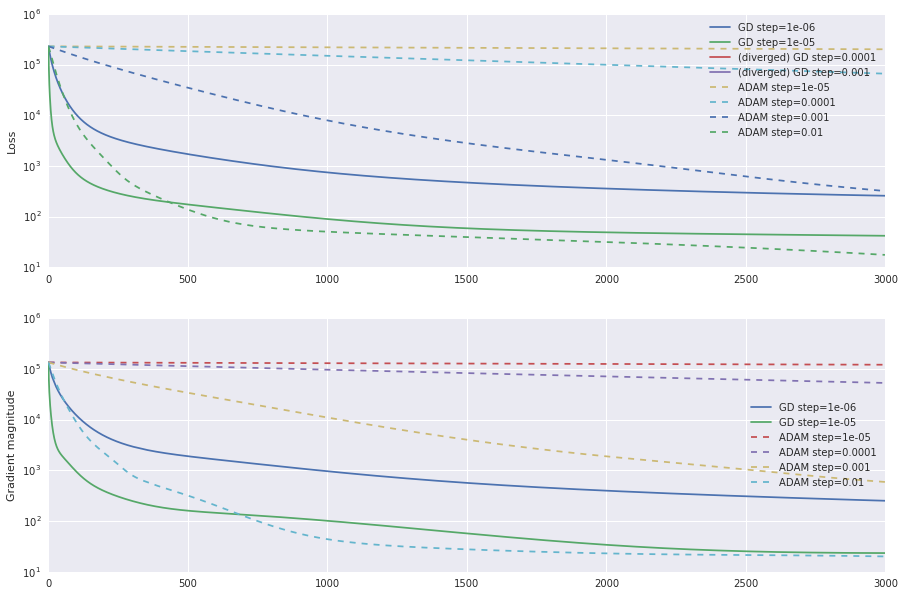

In [0]:
def plot_nets(nets, show_to_max=-1):
  fig = plt.figure(figsize=(15, 10))
  ax1 = fig.add_subplot(2,1,1)
  ax2 = fig.add_subplot(2,1,2)

  for net in nets:
    show_to = -1 if show_to_max > len(net.losses) else show_to_max
      
    if np.isfinite(net.losses[show_to]):
      ax1.semilogy(net.losses[:show_to], label=net.name, **net.plot_kwargs)
      ax2.semilogy(net.gradient_magnitudes[:show_to], label=net.name,
                   **net.plot_kwargs)
    else:
      ax1.semilogy(net.losses[:1], marker='x', label='(diverged) ' + net.name,
                   **net.plot_kwargs)
      
  ax1.set_ylabel('Loss')
  ax1.legend(loc='best')
  ax2.set_ylabel('Gradient magnitude')
  ax2.legend(loc='best')
  return ax1, ax2

plot_nets(nets, -1);

# Is This Really a Problem?

The optimization problem ought to reach $\L = 0$ (the problem is realizable). The loss seems to go down by a few orders of magnitude, but it does not reach 0 to machine precision.

It's tempting to say that the optimization has reached some kind of noise floor for the data set: perhaps adding more data points solves the issue. Not so. Minimizing the expected value of the loss, $\|W_1 W_2 - A\|$, produces similar curves. What we're orbserving has nothing to do with statistics of $\L$. It's entirely about the dynamics of gradient descent on product chains.

Gradient descent hits an optimization floor, not a statistical floor. You don't somehow learn more by adding more data.

# What A Better Optimizer Could Do

Levenberg-Marquardt is the simplest optimizer I can think of that does not require second order information. We'll take steps $(\delta W_1, \delta W_2)$ that minimize an approximation to $\L$:

$$\begin{align}
\L(W_1+\delta W_1, W_2+\delta W_2) &= \E_x \|(W_1+\delta W_1)(W_2+\delta W_2)x - y\|^2 \\
&\approx  \E_x \|(\delta W_1\; W_2+W_1\;\delta W_2)x  + \underbrace{W_1 W_2 x- y}_e\|^2 \\
&=  \E_x \left\|\begin{bmatrix}(W_2x)^T \otimes I, & x^T\otimes W_1\end{bmatrix}\begin{bmatrix}\delta \vec{W}_1 \\ \delta \vec{W}_2\end{bmatrix}  + e\right\|^2.
\end{align}$$

We'll look for the minimizing  $(\delta W_1, \delta W_2)$ by solving this least-squares problem. The algorithm looks a lot like K-FAC or Natural Gradient.

In [0]:
def unpack_vector(x, *lengths):
  """Split up a sequence into several sequences of the given length.
  
  Args:
    x: a sequence
    lengths: a sequence of n lengths.
  Returns:
    A list of sequences v1...vN. vi has length lengths[i].
  """
  vectors = []
  i = 0
  for l in lengths:
    v = x[i:i+l]
    vectors.append(v)
    i += l
  assert i == len(x)
  return vectors


class LevenbergMarquardt(object):
  
  def __init__(self, learning_rate, X, Ytrue, W1_initial, W2_initial):
    self.learning_rate = learning_rate
    self.name = "LM step=%g" % learning_rate
    self.X = X
    self.Ytrue = Ytrue
    self.W1 = W1_initial
    self.W2 = W2_initial
    self.plot_kwargs = {}
    
  def take_step(self):
    "Form and solve the least squares problem above about W1, W2."
    
    Yhat = self.W1.dot(self.W2.dot(self.X))
    RHS = -(Yhat - self.Ytrue).T.flatten()
    
    LHS = np.hstack((
        np.kron(self.W2.dot(self.X).T, np.eye(self.W1.shape[0])),
        np.kron(self.X.T, self.W1)
    ))
          
    # solve the least squares problem and parse the solution into matrices
    dW1dW2 = np.linalg.lstsq(LHS, RHS)[0]
    dW1, dW2 = unpack_vector(dW1dW2, self.W1.size, self.W2.size)
    dW1 = dW1.reshape(self.W1.T.shape).T
    dW2 = dW2.reshape(self.W2.T.shape).T
    
    # apply the update to the iterates
    self.W1 = self.W1 + self.learning_rate * dW1
    self.W2 = self.W2 + self.learning_rate * dW2
    
  def loss(self):
    Yhat = self.W1.dot(self.W2.dot(self.X))
    return np.sum(Yhat - self.Ytrue)**2
    
  def run_optimizer(self, num_steps):
    self.gradient_magnitudes = []
    self.losses = []
    for _ in xrange(num_steps):
      self.take_step()
      self.losses.append(self.loss())
    
    
def train_lm(X, Ytrue, W1_initial, W2_initial):
  nets = []
  for step_sizes in [.05, .2]:
    net = LevenbergMarquardt(step_sizes, X, Ytrue, W1_initial, W2_initial)
    net.run_optimizer(200)
    nets.append(net)
  return nets

nets_lm = train_lm(*initial_params)

(0.0, 190.0, 4.5169799963375946e-08, 228241.57703817962)

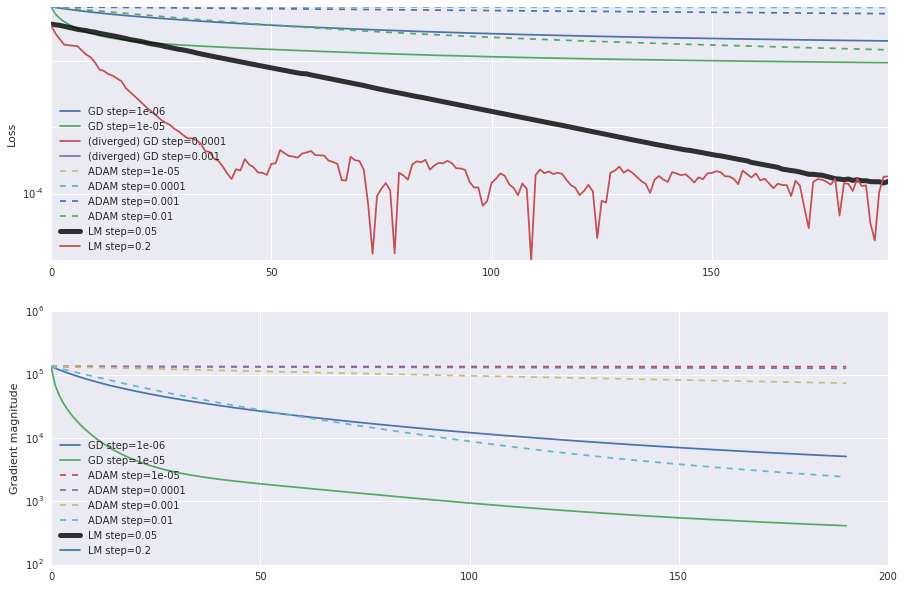

In [0]:
nets_lm[0].plot_kwargs = {'lw': 5, 'color': 'k', 'alpha': .8}
ax1, _ = plot_nets(nets + nets_lm, 191);
ax1.set_yticks(10**np.linspace(-14, 6, 7))
ax1.axis('tight')